In [1]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.model_selection import train_test_split
from scipy import stats

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

#Read input data
df_train = pd.read_csv('house_train.csv')
df_test = pd.read_csv('house_test.csv')


In [27]:
from pathlib import Path
def apply_domain_cleaning(df):
    df = df.copy()
    # 1) NA -> "None"
    none_cols = ["Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2",
                 "FireplaceQu","GarageType","GarageFinish","GarageQual","GarageCond",
                 "PoolQC","Fence","MiscFeature","MasVnrType"]
    for c in none_cols:
        if c in df.columns:
            df[c] = df[c].fillna("None")

    # 2) Zero fill
    zero_cols = ["MasVnrArea","GarageCars","GarageArea","TotalBsmtSF",
                 "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","BsmtFullBath","BsmtHalfBath","PoolArea"]
    for c in zero_cols:
        if c in df.columns:
            df[c] = df[c].fillna(0)

    # 3) LotFrontage median by neighborhood
    if "LotFrontage" in df.columns and "Neighborhood" in df.columns:
        df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
            lambda s: s.fillna(s.median())
        )

    # 4) GarageYrBlt
    if "GarageYrBlt" in df.columns:
        if "GarageType" in df.columns:
            df.loc[df["GarageType"]=="None", "GarageYrBlt"] = df.loc[df["GarageType"]=="None", "GarageYrBlt"].fillna(0)
        if "YearBuilt" in df.columns:
            df["GarageYrBlt"] = df["GarageYrBlt"].fillna(df["YearBuilt"])

    # 5) MSZoning in test
    if "MSZoning" in df.columns and "Neighborhood" in df.columns:
        df["MSZoning"] = df.groupby("Neighborhood")["MSZoning"].transform(
            lambda s: s.fillna(s.mode().iloc[0] if not s.mode().empty else "RL")
        )

    # 6) Electrical mode
    if "Electrical" in df.columns:
        df["Electrical"] = df["Electrical"].fillna(df["Electrical"].mode()[0])

    # 7) Functional NA->Typ
    if "Functional" in df.columns:
        df["Functional"] = df["Functional"].fillna("Typ")

    # 8) Drop Utilities
    if "Utilities" in df.columns:
        df = df.drop(columns=["Utilities"])

    # 9) Feature engineering
    if set(["GrLivArea","TotalBsmtSF"]).issubset(df.columns):
        df["TotalSF"] = df["GrLivArea"] + df["TotalBsmtSF"]
    if set(["FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"]).issubset(df.columns):
        df["Baths_Total"] = df["FullBath"] + 0.5*df["HalfBath"] + df["BsmtFullBath"] + 0.5*df["BsmtHalfBath"]
    if set(["YrSold","YearBuilt"]).issubset(df.columns):
        df["Age_Sold"] = df["YrSold"] - df["YearBuilt"]
    if set(["YrSold","YearRemodAdd"]).issubset(df.columns):
        df["Age_Renov"] = df["YrSold"] - df["YearRemodAdd"]
    if set(["WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch"]).issubset(df.columns):
        df["PorchSF_Total"] = df[["WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch"]].sum(axis=1)
    return df

def drop_grliv_outliers(df):
    return df[~((df["GrLivArea"]>4000) & (df["SalePrice"]<300000))].copy()



In [28]:
# label several label with specific grading system.
def SC_LabelEncoder3(text):
    if text == "Grvl":
        return 1
    elif text == "Pave":
        return 2
    else:
        return 0

def SC_LabelEncoder2(text):
    if text == "A":
        return 1
    elif text == "C":
        return 2
    elif text == "FV":
        return 3
    elif text == "RP":
        return 4
    elif text == "I":
        return 5
    elif text == "RH":
        return 6
    elif text == "RL":
        return 7
    elif text == "RM":
        return 8
    else:
        return 0

def SC_LabelEncoder(text):
    if text == "AllPub":
        return 4
    elif text == "NoSewr":
        return 3
    elif text == "NoSeWa":
        return 2
    elif text == "ELO":
        return 1
    else:
        return  0

def SC_LabelEncoder4(text):
    if text == "1Fam":
        return 1
    elif text == "2FmCon":
        return 2
    elif text == "Duplx":
        return 3
    elif text == "TwnhsE":
        return 4
    elif text == "TwnhsI":
        return 4
    else:
        return 0

def SC_LabelEncoder5(text):

    if text == "Floor":
        return 1
    elif text == "GasA":
        return 2
    elif text == "GasW":
        return 3
    elif text == "Grav":
        return 4
    elif text == "OthW":
        return 5
    elif text == "Wall":
        return 6
    else:
        return 0

def SC_LabelEncoder6(text):
    if text == "Y":
        return 1
    else:
        return 0



df_train["Alley"] = df_train["Alley"].apply(SC_LabelEncoder3)
df_train["MSZoning"] = df_train["MSZoning"].apply(SC_LabelEncoder2)
df_train["Utilities"] = df_train["Utilities"].apply(SC_LabelEncoder)
df_train["BldgType"] = df_train["BldgType"].apply(SC_LabelEncoder4)
df_train["Heating"] = df_train["Heating"].apply(SC_LabelEncoder5)
df_train["CentralAir"] = df_train["CentralAir"].apply(SC_LabelEncoder6)

df_test["Alley"] = df_test["Alley"].apply(SC_LabelEncoder3)
df_test["MSZoning"] = df_test["MSZoning"].apply(SC_LabelEncoder2)
df_test["Utilities"] = df_test["Utilities"].apply(SC_LabelEncoder)
df_test["BldgType"] = df_test["BldgType"].apply(SC_LabelEncoder4)
df_test["Heating"] = df_test["Heating"].apply(SC_LabelEncoder5)
df_test["CentralAir"] = df_test["CentralAir"].apply(SC_LabelEncoder6)

In [29]:
columns_to_keep = ['Id','SalePrice','MoSold','YrSold', 'MSZoning','LotArea','Alley','Utilities','BldgType','OverallCond','YearBuilt','MasVnrArea','TotalBsmtSF', 'Heating', 'CentralAir', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'Fireplaces', 'GarageYrBlt', 'PoolArea', 'WoodDeckSF', 'OpenPorchSF', ]
columns_to_keep1 = ['Id','MoSold','YrSold', 'MSZoning','LotArea','Alley','Utilities','BldgType','OverallCond','YearBuilt','MasVnrArea','TotalBsmtSF', 'Heating', 'CentralAir', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'Fireplaces', 'GarageYrBlt', 'PoolArea', 'WoodDeckSF', 'OpenPorchSF', ]
df_train1 = df_train[columns_to_keep]
df_test1 = df_test[columns_to_keep1]

In [60]:
import numpy as np
from sklearn.preprocessing import StandardScaler

#Inicializar el escalador
scaler = StandardScaler(with_mean=True, with_std=True)

#Normalizar los datos
df_train_normal = scaler.fit_transform(df_train1)
df_train_normal2 = scaler.fit_transform(df_test1)

#Mostrar los registros normalizados
df_train_normal

#Crear de nuevo el DF
df_train_clean = pd.DataFrame(df_train_normal, columns=df_train1.columns)
df_train_clean2= pd.DataFrame(df_train_normal2, columns=df_test1.columns)

In [61]:
x_train = apply_domain_cleaning(df_train_clean)
x_test  = apply_domain_cleaning(df_train_clean2)

print(x_train.shape, x_test.shape)
x_train.head()

(1460, 23) (1459, 22)


,Id,SalePrice,MoSold,YrSold,MSZoning,LotArea,Alley,BldgType,OverallCond,YearBuilt,...,CentralAir,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageYrBlt,PoolArea,WoodDeckSF,OpenPorchSF,Age_Sold
0,-1.730865,0.347273,-1.599111,0.138777,0.0,-0.207142,0.0,0.0,-0.517200,1.050994,...,0.0,0.789741,1.227585,0.163779,-0.951226,0.992426,-0.068692,-0.752176,0.216503,-0.912216
1,-1.728492,0.007288,-0.489110,-0.614439,0.0,-0.091886,0.0,0.0,2.179628,0.156734,...,0.0,0.789741,-0.761621,0.163779,0.600495,-0.101543,-0.068692,1.626195,-0.704483,-0.771172
2,-1.726120,0.536154,0.990891,0.138777,0.0,0.073480,0.0,0.0,-0.517200,0.984752,...,0.0,0.789741,1.227585,0.163779,0.600495,0.911391,-0.068692,-0.752176,-0.070361,-0.845975
3,-1.723747,-0.515281,-1.599111,-1.367655,0.0,-0.096897,0.0,0.0,-0.517200,-1.863632,...,0.0,-1.026041,-0.761621,0.163779,0.600495,0.789839,-0.068692,-0.752176,-0.176048,0.495977
4,-1.721374,0.869843,2.100892,0.138777,0.0,0.375148,0.0,0.0,-0.517200,0.951632,...,0.0,0.789741,1.227585,1.390023,0.600495,0.870874,-0.068692,0.780197,0.563760,-0.812854


### Se moditicó el codigo con las variables a mantener
columns_to_keep = ['Id','SalePrice','MoSold','YrSold', 'MSZoning','LotArea','Alley','Utilities','BldgType','OverallCond','YearBuilt','MasVnrArea','TotalBsmtSF', 'Heating', 'CentralAir', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'Fireplaces', 'GarageYrBlt', 'PoolArea', 'WoodDeckSF', 'OpenPorchSF', ]

In [34]:
print(list(x_train.columns))

['Id', 'SalePrice', 'MoSold', 'YrSold', 'MSZoning', 'LotArea', 'Alley', 'BldgType', 'OverallCond', 'YearBuilt', 'MasVnrArea', 'TotalBsmtSF', 'Heating', 'CentralAir', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'Fireplaces', 'GarageYrBlt', 'PoolArea', 'WoodDeckSF', 'OpenPorchSF', 'Age_Sold']


In [62]:
x_train.describe()

,Id,SalePrice,MoSold,YrSold,MSZoning,LotArea,Alley,BldgType,OverallCond,YearBuilt,...,CentralAir,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageYrBlt,PoolArea,WoodDeckSF,OpenPorchSF,Age_Sold
count,1460.000000,1.460000e+03,1.460000e+03,1.460000e+03,1460.0,1.460000e+03,1460.0,1460.0,1.460000e+03,1.460000e+03,...,1460.0,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1460.000000,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03
mean,0.000000,1.362685e-16,7.543433e-17,3.567436e-14,0.0,-5.840077e-17,0.0,0.0,3.540547e-16,1.046347e-15,...,0.0,1.180182e-16,2.083569e-17,2.141362e-16,-4.866731e-18,-0.052895,1.946692e-17,5.596741e-17,3.041707e-17,3.462436e-14
std,1.000343,1.000343e+00,1.000343e+00,1.000343e+00,0.0,1.000343e+00,0.0,0.0,1.000343e+00,1.000343e+00,...,0.0,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.022627,1.000343e+00,1.000343e+00,1.000343e+00,1.424298e+00
min,-1.730865,-1.838704e+00,-1.969111e+00,-1.367655e+00,0.0,-9.237292e-01,0.0,0.0,-4.112970e+00,-3.287824e+00,...,0.0,-2.841822e+00,-7.616207e-01,-3.514952e+00,-9.512265e-01,-3.287824,-6.869175e-02,-7.521758e-01,-7.044833e-01,-2.518011e+00
25%,-0.865432,-6.415162e-01,-4.891101e-01,-6.144386e-01,0.0,-2.969908e-01,0.0,0.0,-5.171998e-01,-5.719226e-01,...,0.0,-1.026041e+00,-7.616207e-01,-1.062465e+00,-9.512265e-01,-0.749821,-6.869175e-02,-7.521758e-01,-7.044833e-01,-1.029718e+00
50%,0.000000,-2.256643e-01,-1.191097e-01,1.387775e-01,0.0,-1.040633e-01,0.0,0.0,-5.171998e-01,5.737148e-02,...,0.0,7.897405e-01,-7.616207e-01,1.637791e-01,6.004949e-01,-0.020508,-6.869175e-02,-7.521758e-01,-3.270298e-01,-5.107697e-02
75%,0.865432,4.165294e-01,6.208910e-01,8.919936e-01,0.0,1.087080e-01,0.0,0.0,3.817427e-01,9.516316e-01,...,0.0,7.897405e-01,1.227585e+00,1.637791e-01,6.004949e-01,0.911391,-6.869175e-02,5.886506e-01,3.221901e-01,9.585441e-01
max,1.730865,7.228819e+00,2.100892e+00,1.645210e+00,0.0,2.051827e+01,0.0,0.0,3.078570e+00,1.282839e+00,...,0.0,2.605522e+00,3.216791e+00,6.294997e+00,3.703938e+00,1.276047,1.830618e+01,6.087635e+00,7.554198e+00,4.833671e+00


In [ ]:
# Save the DataFrame as a CSV file
x_train.to_csv('/content/drive/MyDrive/ML/housing-prices-ml-project/data/processed/train.csv', index=False)

# Save the DataFrame as a CSV file
x_test.to_csv('/content/drive/MyDrive/ML/housing-prices-ml-project/data/processed/test.csv', index=False)

In [63]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd

#Read input data
train_data = pd.read_csv('/content/drive/MyDrive/ML/housing-prices-ml-project/data/processed/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/ML/housing-prices-ml-project/data/processed/test.csv')

In [64]:
# Specify features and target
X_train = x_train.drop(columns=["Id", "SalePrice"])
Y_train = x_train['SalePrice']

X_test = x_test.drop(columns=["Id"])

### XGBoost

In [65]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize XGBoost regressor
model = XGBRegressor(
    max_depth=3,
    n_estimators=1767,         # equivalent to iterations/max_iter
    learning_rate=0.027,
    min_child_weight=9.869,
    random_state=42,
    subsample=0.6539999999999999,
    colsample_bytree=0.733,
)

# K-Fold CV for regression
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validated predictions
y_pred_cv = cross_val_predict(model, X_train, Y_train, cv=cv)

# Calculate metrics
mse = mean_squared_error(Y_train, y_pred_cv)
r2 = r2_score(Y_train, y_pred_cv)
rmse = np.sqrt(mse)  # Compute RMSE
print(f"CV Root Mean Squared Error: {rmse:.3f}")
print("Cross-validated R²:", round(r2, 3))

# Calculate cross-validated scores
mse_scores = -cross_val_score(model, X_train, Y_train, cv=cv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(mse_scores)  # RMSE per fold
r2_scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring='r2')
print("Max CV RMSE:", round(rmse_scores.max(), 3))
print("Min CV RMSE:", round(rmse_scores.min(), 3))
print("Max CV R²:", round(r2_scores.max(), 3))
print("Min CV R²:", round(r2_scores.min(), 3))

# Retrain on the full training set
model.fit(X_train, Y_train)

# Predict on the test set
Y_pred = model.predict(X_test)

CV Root Mean Squared Error: 0.421
Cross-validated R²: 0.822
Max CV RMSE: 0.501
Min CV RMSE: 0.332
Max CV R²: 0.87
Min CV R²: 0.69


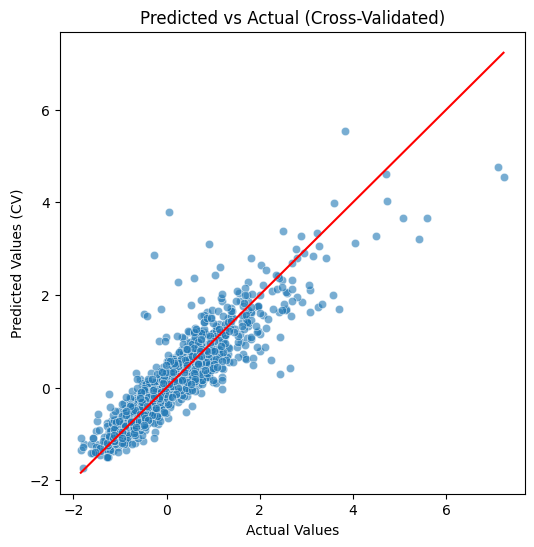

In [66]:
# Predicted vs Actual (CV)
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_train, y=y_pred_cv, alpha=0.6)
sns.lineplot(x=[Y_train.min(), Y_train.max()],
             y=[Y_train.min(), Y_train.max()],
             color="red")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values (CV)")
plt.title("Predicted vs Actual (Cross-Validated)")
plt.show()

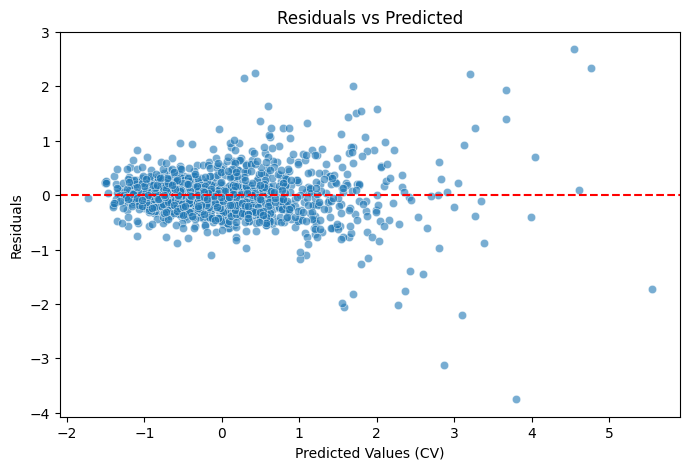

In [67]:
# Residual Plot
residuals = Y_train - y_pred_cv
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_cv, y=residuals, alpha=0.6)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Values (CV)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

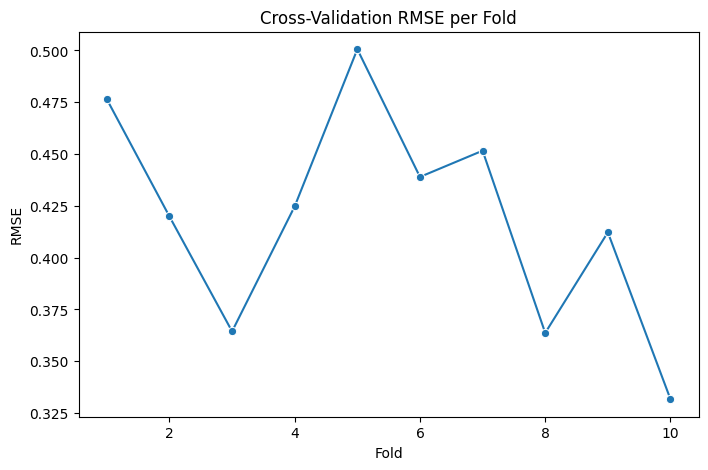

In [68]:
# Cross-Validation RMSE Distribution
plt.figure(figsize=(8,5))
sns.lineplot(x=range(1, len(rmse_scores)+1), y=rmse_scores, marker="o")
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("Cross-Validation RMSE per Fold")
plt.show()

### lightgbm

In [69]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize LightGBM Regressor with tuned parameters
model = LGBMRegressor(
    n_estimators=1000,      # more boosting rounds
    learning_rate=0.05,     # slower, more stable learning
    num_leaves=31,
    max_depth=-1,
    min_child_samples=7,
    max_bin=38,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Get cross-validated predictions
y_pred_cv = cross_val_predict(model, X_train, Y_train, cv=cv)

# Evaluate regression metrics
mse = mean_squared_error(Y_train, y_pred_cv)
rmse = np.sqrt(mse)  # Compute RMSE
r2 = r2_score(Y_train, y_pred_cv)
print(f"CV Root Mean Squared Error: {rmse:.3f}")
print(f"Cross-validated R²: {r2:.4f}")

# Calculate cross-validated scores
mse_scores = -cross_val_score(model, X_train, Y_train, cv=cv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(mse_scores)  # RMSE per fold
r2_scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring='r2')
print("Max CV RMSE:", round(rmse_scores.max(), 3))
print("Min CV RMSE:", round(rmse_scores.min(), 3))
print("Max CV R²:", round(r2_scores.max(), 3))
print("Min CV R²:", round(r2_scores.min(), 3))

# Retrain the model on the full training set
model.fit(X_train, Y_train)

# Make predictions
Y_pred = model.predict(X_test)

CV Root Mean Squared Error: 0.440
Cross-validated R²: 0.8068
Max CV RMSE: 0.615
Min CV RMSE: 0.331
Max CV R²: 0.87
Min CV R²: 0.532


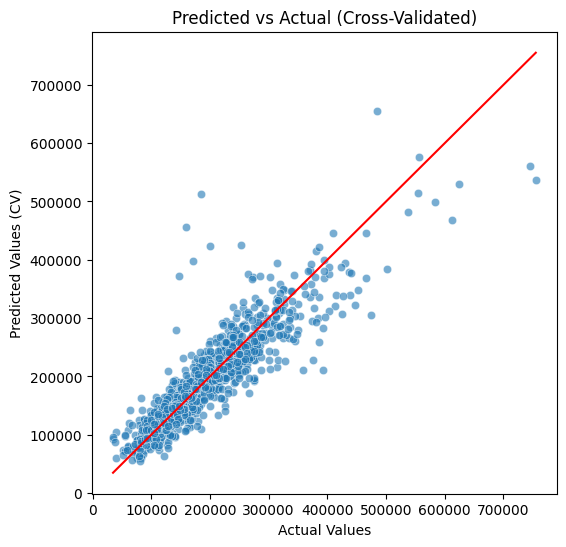

In [43]:
# Predicted vs Actual (CV)
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_train, y=y_pred_cv, alpha=0.6)
sns.lineplot(x=[Y_train.min(), Y_train.max()],
             y=[Y_train.min(), Y_train.max()],
             color="red")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values (CV)")
plt.title("Predicted vs Actual (Cross-Validated)")
plt.show()

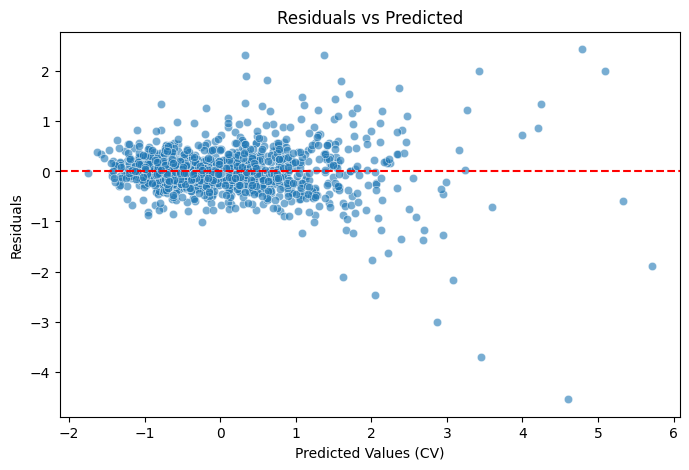

In [70]:
# Residual Plot
residuals = Y_train - y_pred_cv
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_cv, y=residuals, alpha=0.6)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Values (CV)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

Residuals should be scattered randomly around the red horizontal line (0).

Patterns (curves, slopes) → model is missing structure (e.g., nonlinear effects).

Funnel shape (wider spread at higher predictions) → heteroscedasticity (variance grows with target).

Outliers → large residuals worth investigating.

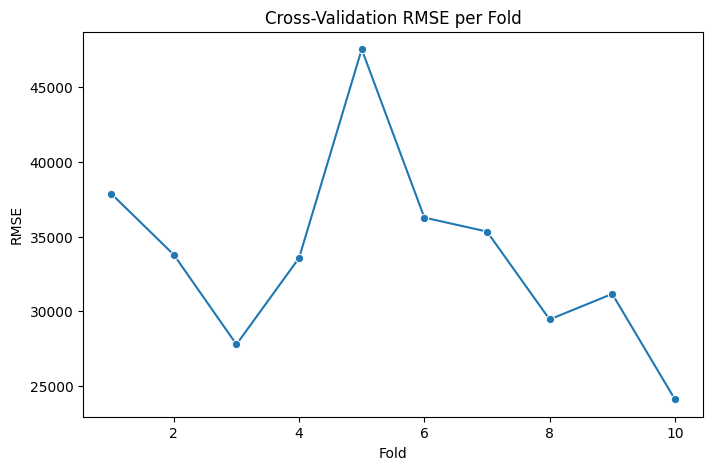

In [45]:
# Cross-Validation RMSE Distribution
plt.figure(figsize=(8,5))
sns.lineplot(x=range(1, len(rmse_scores)+1), y=rmse_scores, marker="o")
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("Cross-Validation RMSE per Fold")
plt.show()

### Catboost

In [46]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


In [71]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize CatBoost regressor (silent logging with verbose=0)
model = CatBoostRegressor(
    depth=3,
    learning_rate=0.092,
    random_strength=2.534,
    verbose=0,
    l2_leaf_reg=2.055,
    border_count=135,
    bagging_temperature=1.37,
    iterations=1247,
)

# K-Fold CV for regression
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validated predictions
y_pred_cv = cross_val_predict(model, X_train, Y_train, cv=cv)

# Regression metrics
mse = mean_squared_error(Y_train, y_pred_cv)
rmse = np.sqrt(mse)  # Compute RMSE
r2 = r2_score(Y_train, y_pred_cv)
print(f"CV Root Mean Squared Error: {rmse:.3f}")
print(f"CV R² Score: {r2:.3f}")

# Calculate cross-validated scores
mse_scores = -cross_val_score(model, X_train, Y_train, cv=cv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(mse_scores)  # RMSE per fold
r2_scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring='r2')
print("Max CV RMSE:", round(rmse_scores.max(), 3))
print("Min CV RMSE:", round(rmse_scores.min(), 3))
print("Max CV R²:", round(r2_scores.max(), 3))
print("Min CV R²:", round(r2_scores.min(), 3))

# Retrain on the full training set
model.fit(X_train, Y_train)

# Predict on the test set
Y_pred = model.predict(X_test)

CV Root Mean Squared Error: 0.421
CV R² Score: 0.822
Max CV RMSE: 0.535
Min CV RMSE: 0.326
Max CV R²: 0.88
Min CV R²: 0.646


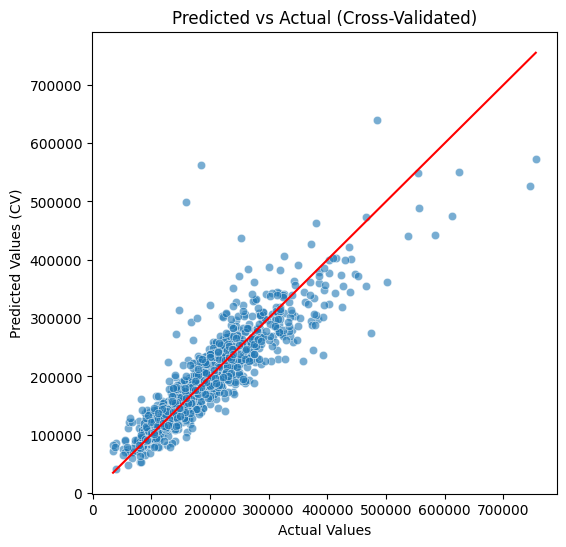

In [48]:
# Predicted vs Actual (CV)
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_train, y=y_pred_cv, alpha=0.6)
sns.lineplot(x=[Y_train.min(), Y_train.max()],
             y=[Y_train.min(), Y_train.max()],
             color="red")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values (CV)")
plt.title("Predicted vs Actual (Cross-Validated)")
plt.show()

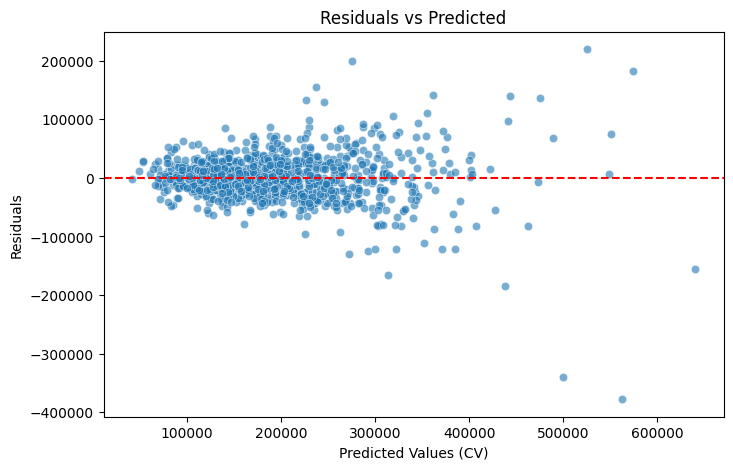

In [49]:
# Residual Plot
residuals = Y_train - y_pred_cv
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_cv, y=residuals, alpha=0.6)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Values (CV)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

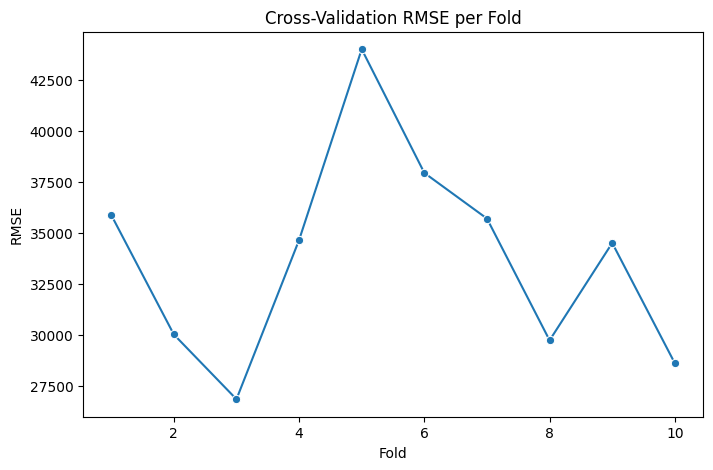

In [50]:
# Cross-Validation RMSE Distribution
plt.figure(figsize=(8,5))
sns.lineplot(x=range(1, len(rmse_scores)+1), y=rmse_scores, marker="o")
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("Cross-Validation RMSE per Fold")
plt.show()

### Random Forest

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize and fit the Random Forest Regressor with chosen parameters
model = RandomForestRegressor(
    n_estimators=1571,      # Number of trees
    max_depth=13,           # Maximum depth of each tree
    min_samples_split=2,
    min_samples_leaf=2,    # Minimum samples per leaf
    max_features=0.812,
    random_state=42,
    n_jobs=-1              # Use all available cores
)

# Cross-validation setup for regression (no stratification needed)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Get cross-validated predictions
y_pred_cv = cross_val_predict(model, X_train, Y_train, cv=cv)

# Calculate and print regression metrics on CV predictions
mse_cv = mean_squared_error(Y_train, y_pred_cv)
r2_cv = r2_score(Y_train, y_pred_cv)
rmse = np.sqrt(mse_cv)  # Compute RMSE
print(f"CV Root Mean Squared Error: {rmse:.3f}")
print(f"Cross-validated R²: {r2_cv:.3f}")

# Calculate cross-validated scores
mse_scores = -cross_val_score(model, X_train, Y_train, cv=cv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(mse_scores)  # RMSE per fold
r2_scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring='r2')
print("Max CV RMSE:", round(rmse_scores.max(), 3))
print("Min CV RMSE:", round(rmse_scores.min(), 3))
print("Max CV R²:", round(r2_scores.max(), 3))
print("Min CV R²:", round(r2_scores.min(), 3))

# Retrain the model on the full training set
model.fit(X_train, Y_train)

# Make predictions on test set
Y_pred = model.predict(X_test)

CV Root Mean Squared Error: 0.439
Cross-validated R²: 0.807
Max CV RMSE: 0.581
Min CV RMSE: 0.334
Max CV R²: 0.874
Min CV R²: 0.582


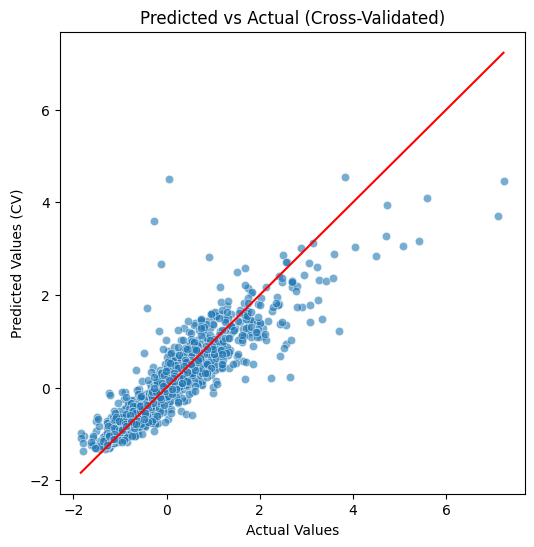

In [73]:
# Predicted vs Actual (CV)
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_train, y=y_pred_cv, alpha=0.6)
sns.lineplot(x=[Y_train.min(), Y_train.max()],
             y=[Y_train.min(), Y_train.max()],
             color="red")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values (CV)")
plt.title("Predicted vs Actual (Cross-Validated)")
plt.show()


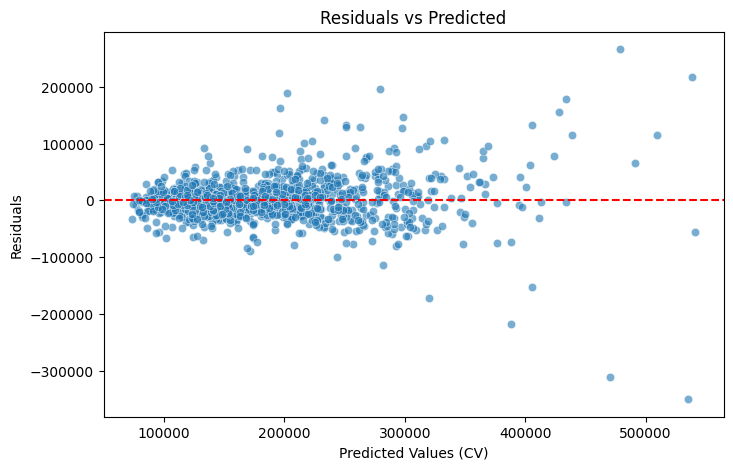

In [53]:
# Residual Plot
residuals = Y_train - y_pred_cv
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_cv, y=residuals, alpha=0.6)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Values (CV)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

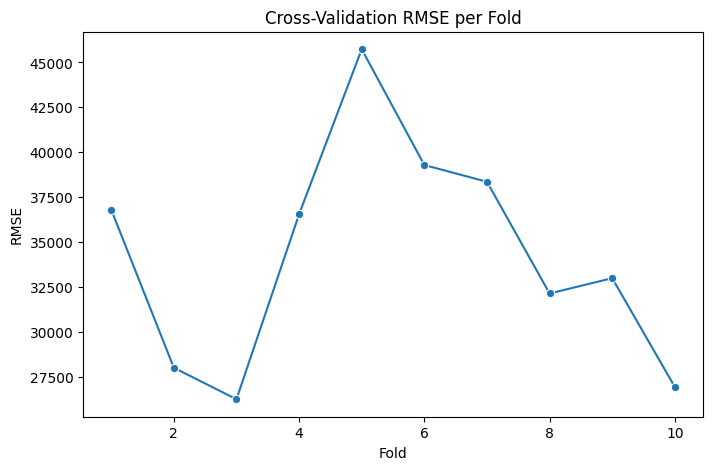

In [54]:
# Cross-Validation RMSE Distribution
plt.figure(figsize=(8,5))
sns.lineplot(x=range(1, len(rmse_scores)+1), y=rmse_scores, marker="o")
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("Cross-Validation RMSE per Fold")
plt.show()

### HistGradientBoostingClassifier


In [74]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize and fit the model with the best parameters
model = HistGradientBoostingRegressor(
    min_samples_leaf=17,
    max_iter=1163,
    max_depth=2,
    max_bins=209,
    learning_rate=0.093,
    early_stopping=True
)

# K-Fold cross-validation (no stratification needed for regression)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Get cross-validated predictions
y_pred_cv = cross_val_predict(model, X_train, Y_train, cv=cv)

# Calculate regression metrics on CV predictions
mse = mean_squared_error(Y_train, y_pred_cv)
r2 = r2_score(Y_train, y_pred_cv)
rmse = np.sqrt(mse)  # Compute RMSE
print(f"CV Root Mean Squared Error: {rmse:.3f}")
print(f"Cross-validated R²: {r2:.3f}")

# Calculate cross-validated scores
mse_scores = -cross_val_score(model, X_train, Y_train, cv=cv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(mse_scores)  # RMSE per fold
r2_scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring='r2')
print("Max CV RMSE:", round(rmse_scores.max(), 3))
print("Min CV RMSE:", round(rmse_scores.min(), 3))
print("Max CV R²:", round(r2_scores.max(), 3))
print("Min CV R²:", round(r2_scores.min(), 3))

# Retrain the model on the full training set
model.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = model.predict(X_test)

CV Root Mean Squared Error: 0.461
Cross-validated R²: 0.787
Max CV RMSE: 0.554
Min CV RMSE: 0.364
Max CV R²: 0.854
Min CV R²: 0.626


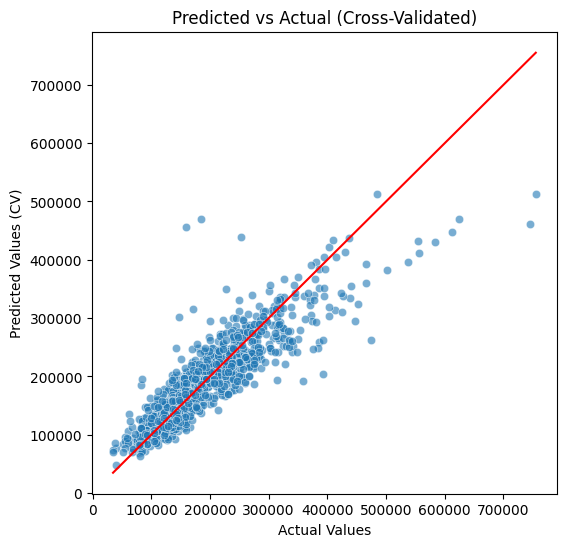

In [56]:
# Predicted vs Actual (CV)
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_train, y=y_pred_cv, alpha=0.6)
sns.lineplot(x=[Y_train.min(), Y_train.max()],
             y=[Y_train.min(), Y_train.max()],
             color="red")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values (CV)")
plt.title("Predicted vs Actual (Cross-Validated)")
plt.show()

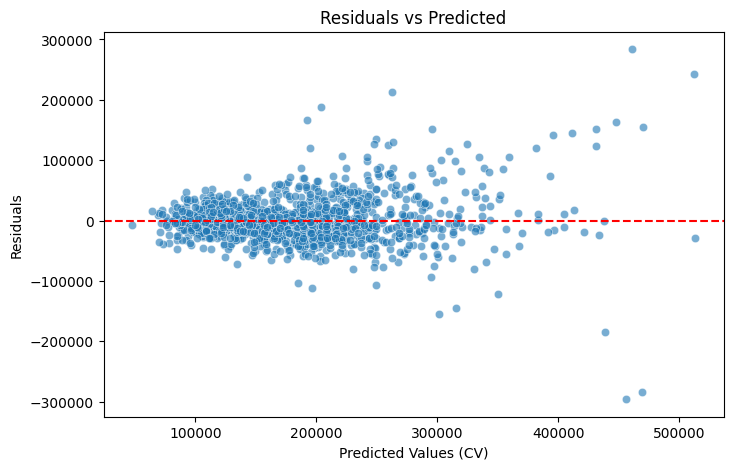

In [57]:
# Residual Plot
residuals = Y_train - y_pred_cv
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_cv, y=residuals, alpha=0.6)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Values (CV)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

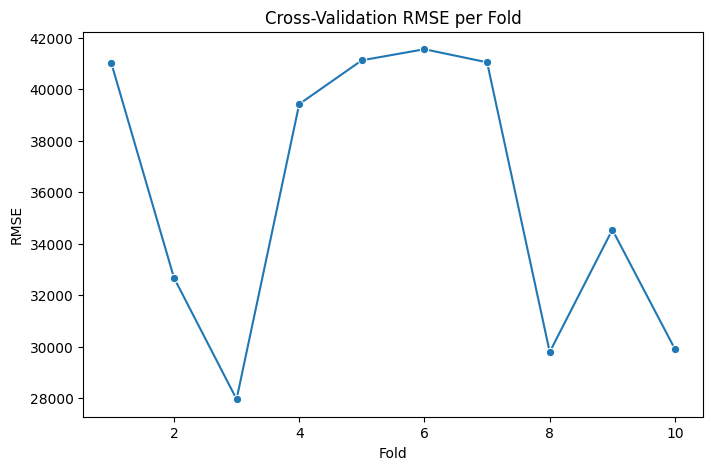

In [58]:
# Cross-Validation RMSE Distribution
plt.figure(figsize=(8,5))
sns.lineplot(x=range(1, len(rmse_scores)+1), y=rmse_scores, marker="o")
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("Cross-Validation RMSE per Fold")
plt.show()

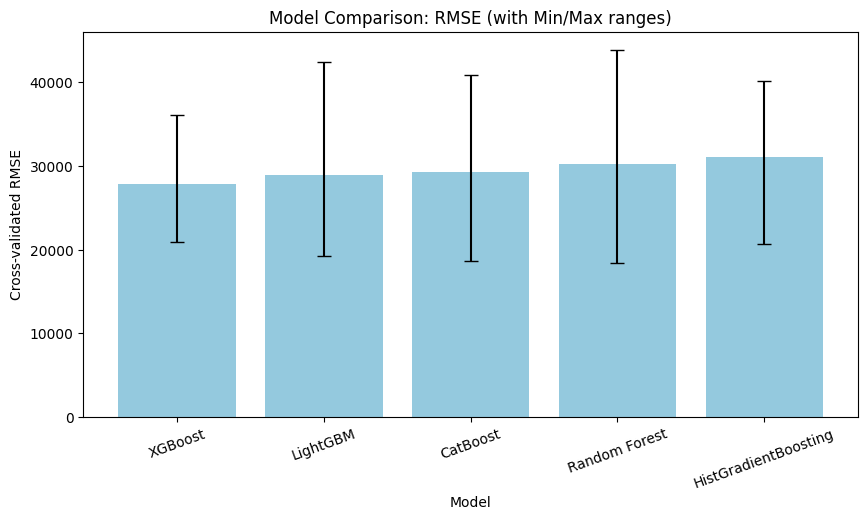

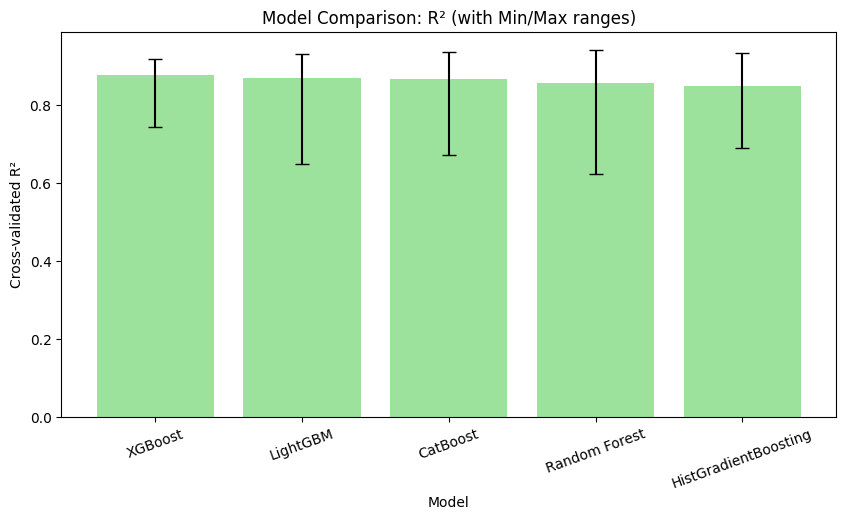

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Put your results into a DataFrame
data = {
    "Model": ["XGBoost", "LightGBM", "CatBoost", "Random Forest", "HistGradientBoosting"],
    "CV_RMSE": [27841.426, 28886.376, 29230.197, 30282.254, 31050.184],
    "Min_RMSE": [20967.158, 19192.945, 18601.993, 18339.738, 20612.484],
    "Max_RMSE": [36076.864, 42423.131, 40885.089, 43843.27, 40144.259],
    "CV_R2": [0.877, 0.8677, 0.865, 0.855, 0.847],
    "Min_R2": [0.744, 0.647, 0.672, 0.623, 0.69],
    "Max_R2": [0.918, 0.931, 0.935, 0.94, 0.933],
}

df = pd.DataFrame(data)

# Compute error bars
df["RMSE_err_low"] = df["CV_RMSE"] - df["Min_RMSE"]
df["RMSE_err_high"] = df["Max_RMSE"] - df["CV_RMSE"]

df["R2_err_low"] = df["CV_R2"] - df["Min_R2"]
df["R2_err_high"] = df["Max_R2"] - df["CV_R2"]

# --- Plot RMSE ---
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="Model", y="CV_RMSE", color="skyblue", errorbar=None)
plt.errorbar(df["Model"], df["CV_RMSE"],
             yerr=[df["RMSE_err_low"], df["RMSE_err_high"]],
             fmt='none', c='black', capsize=5)
plt.ylabel("Cross-validated RMSE")
plt.title("Model Comparison: RMSE (with Min/Max ranges)")
plt.xticks(rotation=20)
plt.show()

# --- Plot R² ---
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="Model", y="CV_R2", color="lightgreen", errorbar=None)
plt.errorbar(df["Model"], df["CV_R2"],
             yerr=[df["R2_err_low"], df["R2_err_high"]],
             fmt='none', c='black', capsize=5)
plt.ylabel("Cross-validated R²")
plt.title("Model Comparison: R² (with Min/Max ranges)")
plt.xticks(rotation=20)
plt.show()